In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# Paths to your dataset
original_data_dir = '/content/drive/MyDrive/Tea Leafs/tea sickness dataset'
base_dir = '/content/tea_leaves_split/'

# Create directories for train and validation splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

categories = ['algal_leaf', 'anthracnose', 'bird_eye_spot', 'brown_blight', 'gray_light', 'healthy']

for category in categories:
    # Create category directories in train and validation folders
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, category), exist_ok=True)

    # Get list of files
    files = os.listdir(os.path.join(original_data_dir, category))

    # Split the data
    train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)

    # Move files to respective directories
    for file in train_files:
        shutil.copy(os.path.join(original_data_dir, category, file),
                    os.path.join(train_dir, category, file))

    for file in val_files:
        shutil.copy(os.path.join(original_data_dir, category, file),
                    os.path.join(validation_dir, category, file))


In [4]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation data
valid_datagen = ImageDataGenerator(rescale=1./255)

# Generators for loading the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 479 images belonging to 6 classes.
Found 121 images belonging to 6 classes.


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load MobileNetV2 without the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)  # 6 classes: 5 diseases and healthy

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,  # Start with a higher number, let early stopping decide when to stop
    callbacks=[early_stopping]
)



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.2440 - loss: 1.8360 - val_accuracy: 0.5521 - val_loss: 1.2292
Epoch 2/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5312 - loss: 1.3011

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - accuracy: 0.5312 - loss: 1.3011 - val_accuracy: 0.6000 - val_loss: 1.1193
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5278 - loss: 1.2348 - val_accuracy: 0.6562 - val_loss: 0.9351
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.6250 - loss: 0.9453 - val_accuracy: 0.7200 - val_loss: 0.8503
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6423 - loss: 1.0045 - val_accuracy: 0.7396 - val_loss: 0.7618
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6875 - loss: 0.7369 - val_accuracy: 0.7600 - val_loss: 0.7049
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6998 - loss: 0.8216 - val_accuracy: 0.7604 - val_loss: 0.7269
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.7500 - loss: 0.7492 - val_accuracy: 0.9200 - val_loss: 0.4322
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6891 - loss: 0.7666 - val_accuracy: 0.6979 - val_loss: 0.69

In [8]:
def predict_with_threshold(image, model, threshold=0.7):
    predictions = model.predict(image)
    max_prob = np.max(predictions)
    if max_prob < threshold:
        return "Non-Tea Leaf"
    else:
        return categories[np.argmax(predictions)]


In [9]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

# Save the model to your Google Drive
model_save_path = '/content/drive/My Drive/tea_leaf_disease_classifier.h5'
model.save(model_save_path)


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7376 - loss: 0.6464


Validation Loss: 0.6519643068313599
Validation Accuracy: 0.7190082669258118


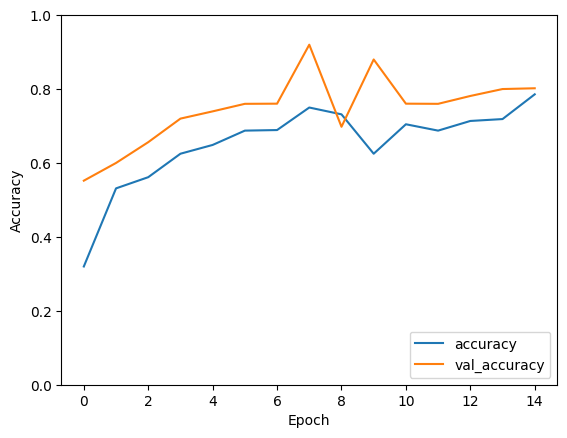

In [10]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


#Testing the Model

In [11]:
from tensorflow.keras.models import load_model

# Load the model
model_path = '/content/drive/My Drive/tea_leaf_disease_classifier.h5'
model = load_model(model_path)


In [12]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training data
    return img_array


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction: ('gray_light', 0.6257682)


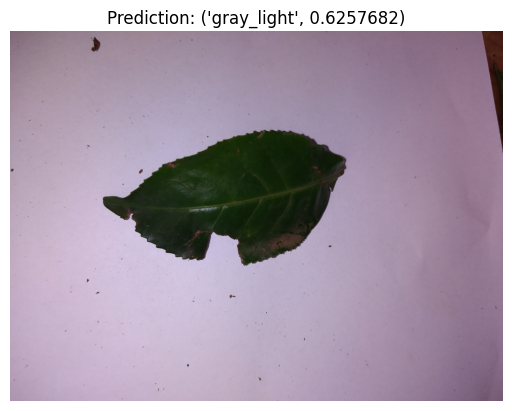

In [29]:
def predict_image(img_path, model, threshold=0.3):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    max_prob = np.max(predictions)

    if max_prob < threshold:
        return "Non-Tea Leaf"
    else:
        predicted_class = np.argmax(predictions)
        class_names = ['algal_leaf', 'anthracnose', 'bird_eye_spot', 'brown_blight', 'gray_light', 'healthy']
        return class_names[predicted_class], max_prob

# Example usage:
test_image_path = '/content/drive/MyDrive/Tea Leafs/tea sickness dataset/gray_light/IMG_20220503_141503.jpg'
result = predict_image(test_image_path, model)
print(f"Prediction: {result}")

def show_image_with_prediction(img_path, result):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Prediction: {result}')
    plt.axis('off')
    plt.show()

# Example usage:
show_image_with_prediction(test_image_path, result)
